# Step 1 : Feature Matching

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

In [22]:
Imgs = []
for file in glob.glob('Data\FeatureMatching\*.jpg'):
    Imgs.append(cv2.imread(file))

In [29]:
class FeatureMatching:
    
    def __init__(self, Imgs):
        self.Imgs = Imgs
        print(f'Number of images for feature matching : {len(self.Imgs)}')
    
    def GeneratePyramids(self, img_index, num_levels, subsample_factor, sigma_blur):
        self.pyramid_total_levels = num_levels
        self.pyramid_subsample_factor = subsample_factor
        self.pyramid_sigma_blur = sigma_blur
        
        img = self.Imgs[img_index]
        pyramids = [img]
        for i in range(1, self.pyramid_total_levels):
            pyramid = self.create_pyramid(pyramids[-1])
            pyramids.append(pyramid)
        return pyramids
    
    def create_pyramid(self, curr_level_img):
        plt.imshow(curr_level_img)
        img = cv2.GaussianBlur(curr_level_img, (5, 5), self.pyramid_sigma_blur)
        img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))
        return img

In [30]:
temp = FeatureMatching(Imgs)
temp

Number of images for feature matching : 2


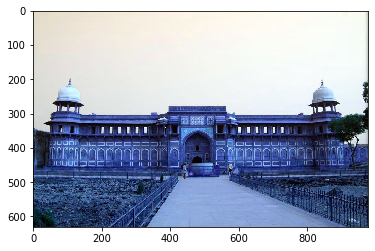

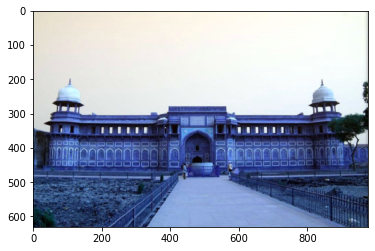

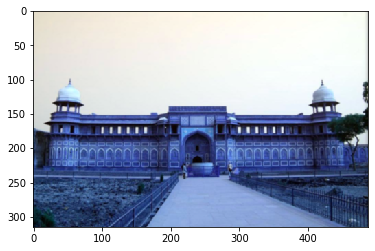

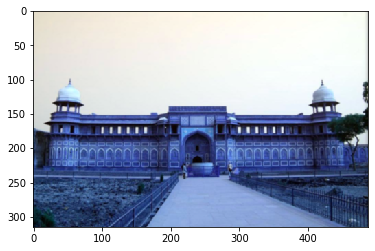

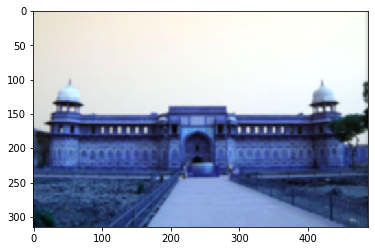

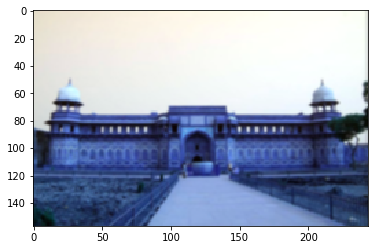

In [31]:
tmp = temp.GeneratePyramids(0, 3, 2, 1.5)